<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/inception_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implimentation of Inception V3 on Cifar-100

**Mission Statement**

1. Impliment Inception V3 from scratch

2. Train our model on Cifar-100

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.2 MB/s eta 0:00:00


## Introduction to Inception V3

**Inception V2** and **Inception V3** were presented in the same paper [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567v3.pdf). In the paper, the authors proposed a number of upgrades which increased the accuracy and reduced the computational complexity.

The major modification done on the Inception V3 model are:

1. Factorization into Smaller Convolutions
2. Spatial Factorization into Asymmetric Convolutions
3. Expanded Feature Banks
4. Efficient Grid Size Reduction





## Factorization into Smaller Convolutions

Inception V2 and V3 model attempt to reduce number of parameters and computational cost by factorization of larger convolutions into smaller convolutions resulted in a relative gain of 28%

Below shows the Inception V1 module

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inceptionv1_module.png?raw=true">

Convolutions with larger spatial filters (eg. 5x5 or 7x7) tend to be disproportionally expsensive in terms of computation. For example, as per the research paper, a 5x5 convolution with n filters over a grid with m filters is 25/9 = 2.78 times more computationally expensive than a 3x3 convolution wiht the same number of filters. While the 5c5 filter capture dependcies between signals between activation of units further away in the earlier layers, a reduciton of the geometric size of the filters comes at a large cost of expressiveness. The author note that the computation graph of the 5x5 convolution looks like a small fully-connected network sliding over 5x5 tiles over its input. Replacing the 5x5 by a multi-layer network with less parameters with the same input size and output depth shows in a control experiment that replacement managed to gain enahnced space of variation with ReLU activation especially if batch normalization is applied.

Below shows the Inception V3 Module A

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inceptionv3_module.png?raw=true">

## Spatial Factorization into Asymmetric Convolutions

Even though the larger convolutions are factorized into smaller convolutions. To further factorize, a better alternative to make the model more efficient was using Asymmetric Convolutions. To replace the 3x3 convolution with a 1x3 convolution followed by a 3x1 convolution. Doing so is the same as sliding a 2-layer network with the same receptive filed as in a 3x3 convolution. They found this method to be 33% more chepaer than the single 3x3 convolution.

Below shows the the Inception V3 Module B

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inceptionv3_asymmetric.png?raw=true">


## Expanded feature banks

The feature banks in the module were expanded (made wider instead of deeper) to remove the prepresentational bottlenetck. If the module was made deeper instead, there would be excessive reduction in dimenions, and hence loss of information

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inceptionv3_filterbank.png?raw=true">



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Optional

class BasicConv2d(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 **kwargs: Any):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class InceptionA(nn.Module):
    def __init__(self,
                 in_channels: int,
                 pool_features: int):
        super().__init__()
        conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        return torch.cat([branch1x1, branch5x5, branch3x3dbl, branch_pool], 1)


class InceptionB(nn.Module):
    def __init__(self,
                 in_channels: int):
        super().__init__()
        conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        return torch.cat([branch3x3, branch3x3dbl, branch_pool], 1)


class InceptionC(nn.Module):
    def __init__(self,
                 in_channels: int,
                 channels_7x7: int):
        super().__init__()
        conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        return torch.cat([branch1x1, branch7x7, branch7x7dbl, branch_pool], 1)

class InceptionD(nn.Module):
    def __init__(self,
                 in_channels: int):
        super().__init__()
        conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        return torch.cat([branch3x3, branch7x7x3, branch_pool], 1)


class InceptionE(nn.Module):
    def __init__(self,
                 in_channels: int):
        super().__init__()
        conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        return torch.cat([branch1x1, branch3x3, branch3x3dbl, branch_pool], 1)


## Utility of Auxiliary Classifiers

In the paper, Author stated that Auxiliary classifiers did not result in improved convergence early in the training: the training progression of network with and without side head looks virtually identical before both models reach high accuracy.

Near the end of training, the network with the auxiliary branches starts to overtake the accuracy of the network without any auxiliary branch and reaches a slightly higher plateau.

The auxiliary classifiers act as regularizer. This is supported by the fact that the main classifier of the network performs better if the side branch is batch-normalized or has a dropout layer.

In [3]:
class InceptionAux(nn.Module):
    def __init__(self,
                 in_channels: int,
                 num_classes: int):
        super().__init__()
        conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001  # type: ignore[assignment]

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # print(x.shape)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        # print(x.shape)
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # print(x.shape)
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


## Inception V3 Model

In total, the inception V3 model is made up of 42 layers which is a bit higher than the previous inception V1 and V2 models.


<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/inceptionv3_architecture.png?raw=true">

In [4]:
class Inception3(nn.Module):
    """Simplified Inception V3 implimentation"""
    def __init__(self,
                 num_classes: int = 1000,
                 dropout: float = 0.5):
        super().__init__()

        conv_block = BasicConv2d
        inception_a = InceptionA
        inception_b = InceptionB
        inception_c = InceptionC
        inception_d = InceptionD
        inception_e = InceptionE
        inception_aux = InceptionAux

        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)

        self.AuxLogits = inception_aux(768, num_classes)

        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                stddev = float(m.stddev) if hasattr(m, "stddev") else 0.1  # type: ignore
                torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=stddev, a=-2, b=2)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux = self.AuxLogits(x) if self.training else None
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

## Prepare Cifar100 Dataset and DataLoader

In [5]:
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from torch.utils.data import DataLoader

train_ds = CIFAR100(root='data',
                    train=True,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    download=True)

# To get the mean and standard deviations of cifar10
data_shape = train_ds.data.shape
data_mean = train_ds.data.mean(axis=(0, 1, 2))/255
data_std = train_ds.data.std(axis=(0, 1, 2))/255

# Define transforms from PIL to Tensors
tfms = T.Compose([
    T.Resize(size=(299, 299)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define transforms from PIL to Tensors with Data Augmentation
tfms_augmented = T.Compose([
    T.Resize(size=(299, 299)),
    T.TrivialAugmentWide(num_magnitude_bins=10),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define reverse transforms from Tensors to PIL (for visualisation)
rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std=list(map(lambda x: 1 / x, data_std))),
    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Apply transforms to dataset
train_ds = CIFAR100(root='data',
                    train=True,
                    transform=tfms_augmented,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    transform=tfms,
                    download=True)


# Create DataLoader for train/valid dataset
train_dl = DataLoader(dataset=train_ds,
                      batch_size=128,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=128,
                      shuffle=False)

100%|██████████| 169001437/169001437 [00:01<00:00, 102960395.39it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Prepare for model training

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sstorch.vision.cifar100 import superclass_labels

# Define loss_fn
def loss_fn(y_logits, y):
    loss_main = F.cross_entropy(y_logits[0], y)
    loss_aux = F.cross_entropy(y_logits[1], y) if y_logits[1] is not None else 0
    # loss_aux2 = F.cross_entropy(y_logits[2], y) if y_logits[1] is not None else 0
    return loss_main + 0.4 * loss_aux

# Define metric_fn that returns dictionary of accuracy, top_5_accuracy and accuracy_super
def metric_fn(y_logits, y):
    # Get Probs and Probabilities using softmax and argmax
    y_probs = y_logits[0].softmax(dim=-1).detach().cpu().numpy()
    y_preds = y_probs.argmax(axis=-1)
    y = y.detach().cpu().numpy()

    # Transform to superclass labels
    y_preds_super = superclass_labels[y_preds]
    y_super = superclass_labels[y]

    accuracy = accuracy_score(y, y_preds)
    top_5_accuracy = top_k_accuracy_score(y, y_probs, k=5, labels=list(range(100)))
    accuracy_super = accuracy_score(y_super, y_preds_super)
    return {'accuracy': accuracy,
            'top_5_accuracy': top_5_accuracy,
            'accuracy_super': accuracy_super}

# Initialise model
model = Inception3(num_classes=100)

# Define optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

In [12]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Inception3 (Inception3)                  [128, 3, 299, 299]   [128, 100]           2,634,596            True
├─BasicConv2d (Conv2d_1a_3x3)            [128, 3, 299, 299]   [128, 32, 149, 149]  --                   True
│    └─Conv2d (conv)                     [128, 3, 299, 299]   [128, 32, 149, 149]  864                  True
│    └─BatchNorm2d (bn)                  [128, 32, 149, 149]  [128, 32, 149, 149]  64                   True
├─BasicConv2d (Conv2d_2a_3x3)            [128, 32, 149, 149]  [128, 32, 147, 147]  --                   True
│    └─Conv2d (conv)                     [128, 32, 149, 149]  [128, 32, 147, 147]  9,216                True
│    └─BatchNorm2d (bn)                  [128, 32, 147, 147]  [128, 32, 147, 147]  64                   True
├─BasicConv2d (Conv2d_2b_3x3)            [128, 32, 147, 147]  [128, 64, 147, 147]  --                   True
│    └─Conv2d 

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 6.92E-03 | Lowest Loss: 8.32E-02


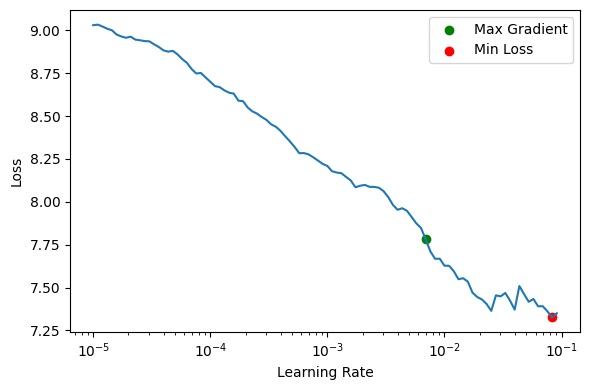

In [9]:
learner.lr_range_test(end_lr=1e-1, start_lr=1e-5)

In [13]:
learner.train(30)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 6.142 | valid_loss: 3.588 
train_metric: {'accuracy': 0.063, 'top_5_accuracy': 0.215, 'accuracy_super': 0.156}
valid_metric: {'accuracy': 0.148, 'top_5_accuracy': 0.409, 'accuracy_super': 0.264}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-03 | train_loss: 5.225 | valid_loss: 3.761 
train_metric: {'accuracy': 0.125, 'top_5_accuracy': 0.351, 'accuracy_super': 0.248}
valid_metric: {'accuracy': 0.213, 'top_5_accuracy': 0.504, 'accuracy_super': 0.355}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-03 | train_loss: 4.657 | valid_loss: 3.053 
train_metric: {'accuracy': 0.188, 'top_5_accuracy': 0.462, 'accuracy_super': 0.325}
valid_metric: {'accuracy': 0.294, 'top_5_accuracy': 0.6, 'accuracy_super': 0.426}
----------------------------------------------------------------------------------------------------
Epo

## Checkpoint Saving

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
learner.save_checkpoint('inception_cifar100.pt')

In [16]:
import shutil
shutil.copy('inception_cifar100.pt', 'gdrive/MyDrive/ssmodel/inception_cifar100.pt')

'gdrive/MyDrive/ssmodel/inception_cifar100.pt'

In [18]:
learner.load_checkpoint('gdrive/MyDrive/ssmodel/inception_cifar100.pt')